# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [2]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt 

%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [4]:
transcript.columns

Index(['person', 'event', 'value', 'time'], dtype='object')

Lets figure out the distribution of the data. 
It will be helpful to find out the proportion of data that is short vs long-term

In [5]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [6]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [7]:
portfolio.shape

(10, 6)

In [8]:
transcript.shape

(306534, 4)

In [9]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [10]:
transcript['event'][0]

'offer received'

In [11]:
portfolio_subset = portfolio[['id', 'offer_type', 'difficulty']]

In [12]:
portfolio_subset

,id,offer_type,difficulty
0,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,3f207df678b143eea3cee63160fa8bed,informational,0
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,20
5,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,7
6,fafdcd668e3743c1bb461111dcafc2a4,discount,10
7,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,2906b810c7d4411798c6938adc9daaa5,discount,10


In [13]:
transcript_subset = transcript.loc[:, ['value', 'event']]

In [14]:
transcript_subset['value']

0         {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2         {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3         {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4         {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
                                ...                       
306529                      {'amount': 1.5899999999999999}
306530                                    {'amount': 9.53}
306531                                    {'amount': 3.61}
306532                      {'amount': 3.5300000000000002}
306533                                    {'amount': 4.05}
Name: value, Length: 306534, dtype: object

In [15]:
transcript_subset = transcript_subset.loc[transcript_subset['value'].apply(lambda x: 'offer id' in x)]

In [16]:
transcript_subset['id'] = transcript_subset['value'].apply(lambda x: list(x.values())[0])

In [17]:
transcript_subset.head()

,value,event,id
0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},offer received,2906b810c7d4411798c6938adc9daaa5
3,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},offer received,fafdcd668e3743c1bb461111dcafc2a4
4,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},offer received,4d5c57ea9a6940dd891ad53e9dbe8da0


In [18]:
portfolio_subset.head()

,id,offer_type,difficulty
0,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,3f207df678b143eea3cee63160fa8bed,informational,0
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,20


In [19]:
merged = pd.merge(transcript_subset, portfolio_subset, on='id', how='inner')

In [20]:
merged.head()

,value,event,id,offer_type,difficulty
0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
1,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,20
2,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},offer received,2906b810c7d4411798c6938adc9daaa5,discount,10
3,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},offer received,fafdcd668e3743c1bb461111dcafc2a4,discount,10
4,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},offer received,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10


In [21]:
merged_counts = merged['offer_type'].value_counts()

In [22]:
merged_counts

offer_type
bogo             55948
discount         51988
informational    26066
Name: count, dtype: int64

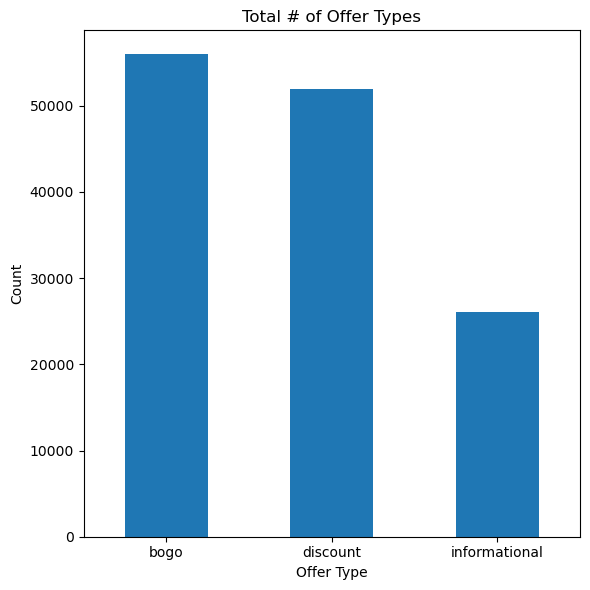

In [23]:
plt.figure(figsize=(6, 6))

# Create bar chart
merged_counts.plot(kind='bar')

# Customize the chart
plt.title("Total # of Offer Types")
plt.xlabel("Offer Type")
plt.ylabel("Count")
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

It seems the least offered type of discount is informational, followed by discount and bogo. There appears to be a preference towards discount strategies.

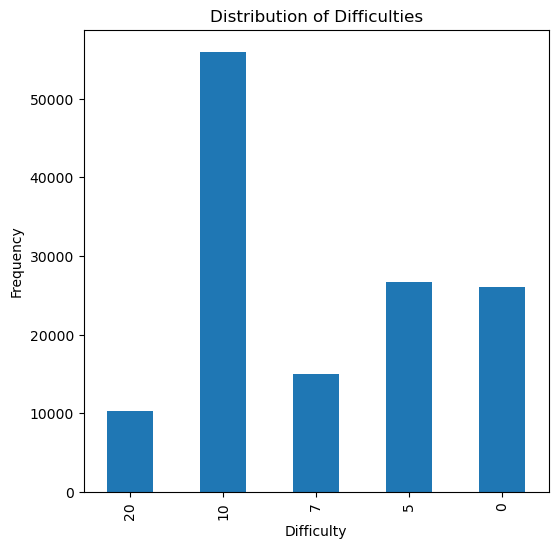

In [24]:
plt.figure(figsize=(6, 6))

difficulties = merged['difficulty'].value_counts().sort_index(ascending=False)

difficulties.plot(kind='bar')

plt.title("Distribution of Difficulties")
plt.xlabel("Difficulty")
plt.ylabel("Frequency")

plt.show()

In [25]:
merged['difficulty'].unique()

array([ 5, 20, 10,  7,  0], dtype=int64)

There are only 5 types of difficulties. According to the chart, the more difficult (ie. less time to use the promotion), the more frequently the promotion is given.

In [26]:
merged.groupby(['offer_type', 'difficulty']).size()

offer_type     difficulty
bogo           5             26683
               10            29265
discount       7             14983
               10            26674
               20            10331
informational  0             26066
dtype: int64

In [27]:

difficult_order_type = merged.groupby(['offer_type', 'difficulty']).size().unstack(fill_value=0)



In [28]:
difficult_order_type

difficulty,0,5,7,10,20
offer_type,,,,,
bogo,0,26683,0,29265,0
discount,0,0,14983,26674,10331
informational,26066,0,0,0,0


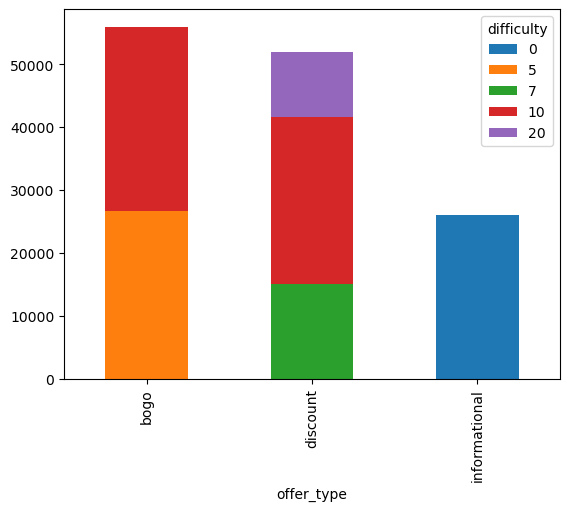

In [29]:
ax = difficult_order_type.plot(kind='bar', stacked=True)

It looks like both BOGO and discout type offers comprise of high difficulties, and that all discount-based promotions have a time limit while informational promotions never expire.

Let's take a look at the distribution of offers in the Portfolio db.

In [30]:
print("asdf")

asdf


In [31]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [32]:
unique_channels = set()
for row in portfolio['channels']:
    unique_channels.update(row)

new_channels = pd.DataFrame()

In [33]:
for channel in unique_channels:
    new_channels[channel] = portfolio['channels'].apply(lambda x: 1 if channel in x else 0)

In [34]:
new_channels.sum(axis=0)

email     10
web        8
mobile     9
social     6
dtype: int64

In [35]:
new_channels.describe()

,email,web,mobile,social
count,10.0,10.000000,10.000000,10.000000
mean,1.0,0.800000,0.900000,0.600000
std,0.0,0.421637,0.316228,0.516398
min,1.0,0.000000,0.000000,0.000000
25%,1.0,1.000000,1.000000,0.000000
50%,1.0,1.000000,1.000000,1.000000
75%,1.0,1.000000,1.000000,1.000000
max,1.0,1.000000,1.000000,1.000000


<Axes: >

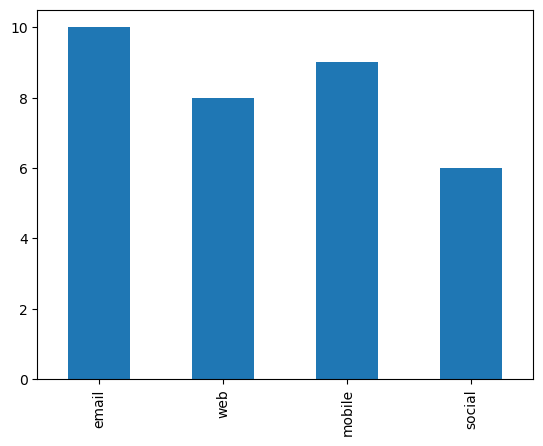

In [36]:
new_channels.sum(axis=0).plot(kind='bar')

Lets do some customer analytics.

In [37]:
# Lets stratify the customer base by gender
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [38]:
profile.gender.unique()

array([None, 'F', 'M', 'O'], dtype=object)

Looks like there are some marked as "None". Let's take a look to make sure they aren't invalid data

In [39]:
none_gender = profile[profile.gender.apply(lambda x: x is None)]

In [40]:
none_gender.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN


Needless to say, I don't think there are any 118 year olds drinking Starbucks. Let's assume this data is invalid and can be safely_removed from the profiles df.

In [41]:
profile_cleaned = profile[profile.gender.apply(lambda x: x is not None)]

In [42]:
#Verify that the nullgender data has been removed
profile_cleaned.gender.unique()

array(['F', 'M', 'O'], dtype=object)

In [43]:
gender_ct = profile.groupby('gender')['gender'].count()

So there are 6129 Female, 8484 Male, and 212 nonbinary customers

In [44]:
x_labels = ["Female", "Male", "Other"]
np.arange(len(x_labels))

array([0, 1, 2])

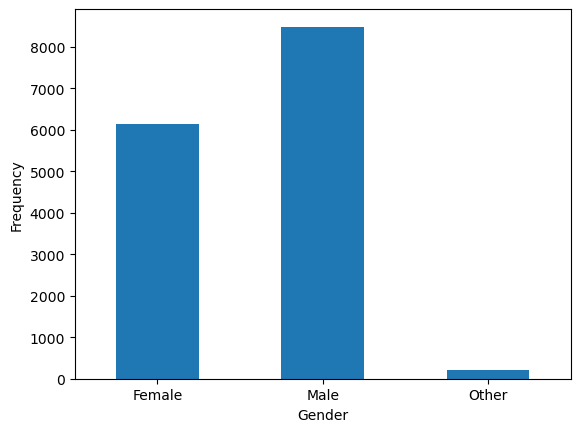

In [45]:
gender_ct.plot(kind='bar', xlabel="Gender", ylabel="Frequency")

plt.xticks(np.arange(len(x_labels)), x_labels, rotation=0)

plt.show()

In [46]:
profile.income.describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

Mean income is 65k USD. The range is from 30k to 120k. 

In [51]:
brackets = [20000, 40000, 60000, 80000, 100000, 120000]
labels = ['20k-40k', '40k-60k', '60k-80k', '80k-100k', '100k-120k']

income_brackets = pd.cut(profile_cleaned.income, bins=brackets, labels=labels, include_lowest=False)





In [52]:
income_brackets.size == profile_cleaned.income.size

True

<Axes: xlabel='income'>

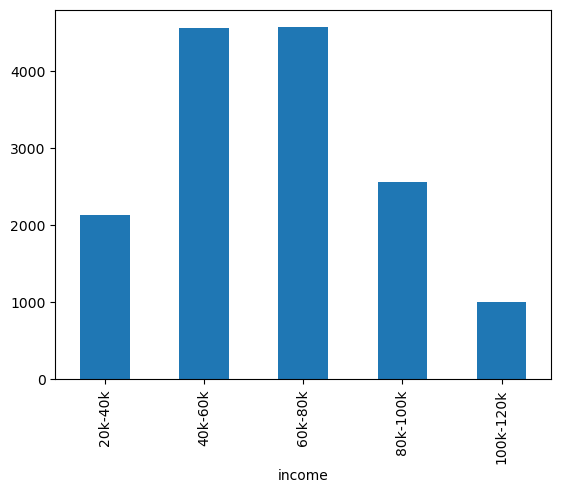

In [53]:
income_brackets.value_counts().sort_index().plot(kind='bar')

Looks like the majority of users make between 40 to 80 k USD per year. 

Before continuing, lets see if there is any other invalid data that needs to be cleaned.

In [54]:
portfolio.isna()

,reward,channels,difficulty,duration,offer_type,id
0,False,False,False,False,False,False
1,False,False,False,False,False,False
2,False,False,False,False,False,False
3,False,False,False,False,False,False
4,False,False,False,False,False,False
5,False,False,False,False,False,False
6,False,False,False,False,False,False
7,False,False,False,False,False,False
8,False,False,False,False,False,False
9,False,False,False,False,False,False


In [55]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [56]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [57]:
transcript.time.describe()

count    306534.000000
mean        366.382940
std         200.326314
min           0.000000
25%         186.000000
50%         408.000000
75%         528.000000
max         714.000000
Name: time, dtype: float64

In [58]:
merged.head()

,value,event,id,offer_type,difficulty
0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
1,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,20
2,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},offer received,2906b810c7d4411798c6938adc9daaa5,discount,10
3,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},offer received,fafdcd668e3743c1bb461111dcafc2a4,discount,10
4,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},offer received,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10


What is the duration of the offers typically?


<Axes: ylabel='Frequency'>

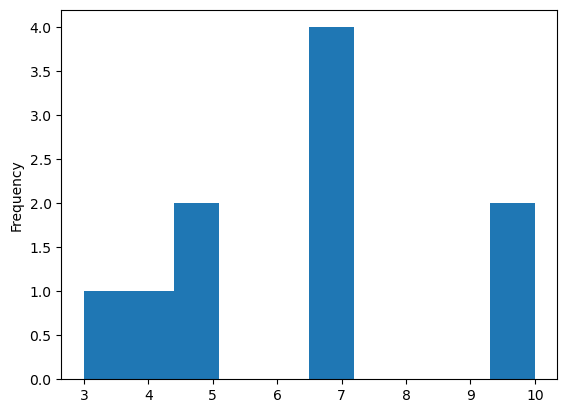

In [59]:
portfolio.duration.plot(kind='hist')

Because there are only 10 data points, it is hard to say whether this is representative of all the promotions, but it seems that 1-week long promotions are the most frequent. 

<Axes: xlabel='duration'>

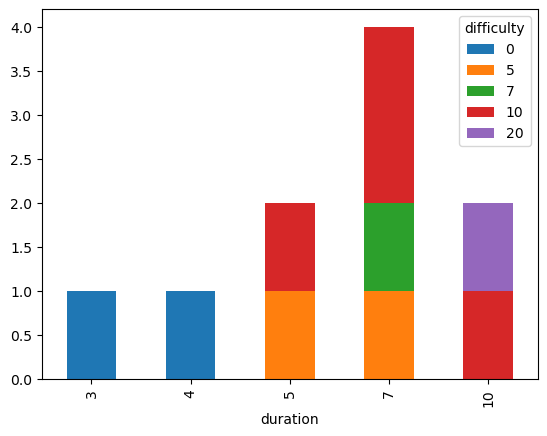

In [60]:
portfolio.groupby(["duration", "difficulty"]).size().unstack(fill_value=0).plot(kind='bar', stacked=True)

It looks like shorter-dated promotions are strictly informational (we've established that all difficulty zero promotions are informational).
Starbucks offers between 5 and 10 days, and the most difficult promotions are given the most amount of time.

Lets see the distribution of offers that are actually completed.

In [61]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [62]:
offer_completed = transcript.loc[transcript.event.apply(lambda x: x == 'offer completed')] 

In [63]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [64]:
offer_completed.head()

,person,event,value,time
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0
12679,629fc02d56414d91bca360decdfa9288,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0
12692,676506bad68e4161b9bbaffeb039626b,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,0
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,0


The next step would be to create a model that 'recommends' whether or not to send an promotion to a customer. 

In order to offer the most breadth, I will join all three datasets.

In [68]:
transcript.explode('value')


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,offer id,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,offer id,0
2,e2127556f4f64592b11af22de27a7932,offer received,offer id,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,offer id,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,offer id,0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,amount,714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,amount,714
306531,a00058cf10334a308c68e7631c529907,transaction,amount,714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,amount,714


In [66]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [69]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [70]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [75]:
transcript.value[0]['offer id']

'9b98b8c7a33c4b65b9aebfe6a799e6d9'

In [83]:
transcript_clone = transcript.copy()
portfolio_clone = portfolio.copy()
profile_clone = profile.copy()

In [86]:
# Extract 'offer_id' from 'value' column
transcript_clone['offer_id'] = transcript_clone['value'].apply(lambda x: x['offer id'] if 'offer id' in x else None)


In [87]:
transcript_clone.head()

,person,event,value,time,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [90]:
transcript_portfolio = pd.merge(transcript_clone, portfolio_clone, left_on='offer_id', right_on='id', how='inner', suffixes=('', '_offer'))

In [94]:
transcript_portfolio.shape

(134002, 11)

In [96]:
final_df = pd.merge(transcript_portfolio, profile_clone, right_on='id', left_on='person', how='inner')

In [99]:
final_df

,person,event,value,time,offer_id,reward,channels,difficulty,duration,offer_type,id_x,gender,age,id_y,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133997,d56386cf344c4829bbf420d1895dca37,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},714,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,None,118,d56386cf344c4829bbf420d1895dca37,20171102,NaN
133998,9b51e8797290403b90d09d864dec4b94,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},714,3f207df678b143eea3cee63160fa8bed,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,F,70,9b51e8797290403b90d09d864dec4b94,20171103,81000.0
133999,84fb57a7fe8045a8bf6236738ee73a0f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},714,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,F,64,84fb57a7fe8045a8bf6236738ee73a0f,20170615,113000.0
134000,abc4359eb34e4e2ca2349da2ddf771b6,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},714,3f207df678b143eea3cee63160fa8bed,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,M,51,abc4359eb34e4e2ca2349da2ddf771b6,20140804,68000.0
